In [1]:
%matplotlib inline


# Layer Normalization


layer-norm:
          N      Triton       Torch
0    1024.0  496.484845  512.000001
1    2048.0  555.389814  537.180338
2    3072.0  455.111110  522.893602
3    4096.0  524.287975  520.126988
4    5120.0  450.109882  515.220116
5    6144.0  517.389457  511.999982
6    7168.0  562.196089  462.451619
7    8192.0  553.046413  504.123076
8    9216.0  504.986281  498.162140
9   10240.0  544.318950  512.000013
10  11264.0  563.200014  473.028883
11  12288.0  573.201179  514.680630
12  13312.0  504.720365  510.772179
13  14336.0  505.233487  499.729845
14  15360.0  493.493967  517.389465


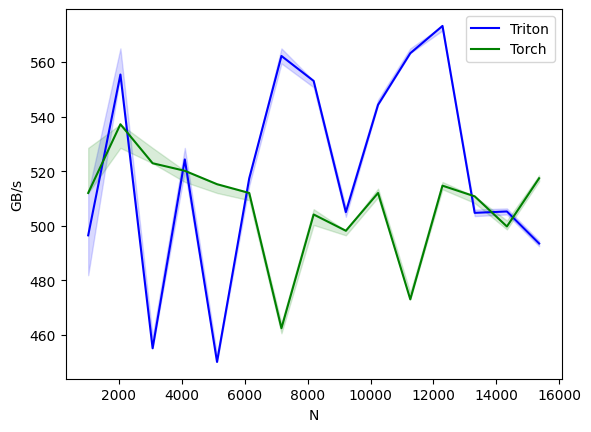

In [4]:
import torch

import triton
import triton.language as tl

try:
    # This is https://github.com/NVIDIA/apex, NOT the apex on PyPi, so it
    # should not be added to extras_require in setup.py.
    import apex
    HAS_APEX = True
except ModuleNotFoundError:
    HAS_APEX = False


@triton.jit
def _layer_norm_fwd_fused(
    Out,
    A,
    Weight,
    Bias,
    Mean, Rstd,
    stride, N, eps,
    BLOCK_SIZE: tl.constexpr,
):
    # position of elements processed by this program
    row = tl.program_id(0)
    Out += row * stride
    A += row * stride
    # compute mean
    mean = 0
    _mean = tl.zeros([BLOCK_SIZE], dtype=tl.float32)
    for off in range(0, N, BLOCK_SIZE):
        cols = off + tl.arange(0, BLOCK_SIZE)
        a = tl.load(A + cols, mask=cols < N, other=0., eviction_policy="evict_last").to(tl.float32)
        _mean += a
    mean = tl.sum(_mean, axis=0) / N
    # compute variance
    _var = tl.zeros([BLOCK_SIZE], dtype=tl.float32)
    for off in range(0, N, BLOCK_SIZE):
        cols = off + tl.arange(0, BLOCK_SIZE)
        a = tl.load(A + cols, mask=cols < N, other=0., eviction_policy="evict_last").to(tl.float32)
        a = tl.where(cols < N, a - mean, 0.)
        _var += a * a
    var = tl.sum(_var, axis=0) / N
    rstd = 1 / tl.sqrt(var + eps)
    # write-back mean/rstd
    tl.store(Mean + row, mean)
    tl.store(Rstd + row, rstd)
    # multiply by weight and add bias
    for off in range(0, N, BLOCK_SIZE):
        cols = off + tl.arange(0, BLOCK_SIZE)
        mask = cols < N
        weight = tl.load(Weight + cols, mask=mask)
        bias = tl.load(Bias + cols, mask=mask)
        a = tl.load(A + cols, mask=mask, other=0., eviction_policy="evict_first").to(tl.float32)
        a_hat = (a - mean) * rstd
        out = a_hat * weight + bias
        # # write-back
        tl.store(Out + cols, out, mask=mask)

# Backward pass (DA + partial DW + partial DB)


@triton.jit
def _layer_norm_bwd_dx_fused(
    _DA,
    _DOut,
    _A,
    Weight,
    Mean, Rstd,
    stride, NumRows, NumCols, eps,
    BLOCK_SIZE_N: tl.constexpr,
):
    # position of elements processed by this program
    pid = tl.program_id(0)
    row = pid
    A = _A + row * stride
    DOut = _DOut + row * stride
    DA = _DA + row * stride
    mean = tl.load(Mean + row)
    rstd = tl.load(Rstd + row)
    # load data to SRAM
    _mean1 = tl.zeros([BLOCK_SIZE_N], dtype=tl.float32)
    _mean2 = tl.zeros([BLOCK_SIZE_N], dtype=tl.float32)
    for off in range(0, NumCols, BLOCK_SIZE_N):
        cols = off + tl.arange(0, BLOCK_SIZE_N)
        mask = cols < NumCols
        a = tl.load(A + cols, mask=mask, other=0).to(tl.float32)
        dout = tl.load(DOut + cols, mask=mask, other=0).to(tl.float32)
        weight = tl.load(Weight + cols, mask=mask, other=0).to(tl.float32)
        a_hat = (a - mean) * rstd
        wdout = weight * dout
        _mean1 += a_hat * wdout
        _mean2 += wdout
    mean1 = tl.sum(_mean1, axis=0) / NumCols
    mean2 = 0.
    mean2 = tl.sum(_mean2, axis=0) / NumCols
    for off in range(0, NumCols, BLOCK_SIZE_N):
        cols = off + tl.arange(0, BLOCK_SIZE_N)
        mask = cols < NumCols
        a = tl.load(A + cols, mask=mask, other=0).to(tl.float32)
        dout = tl.load(DOut + cols, mask=mask, other=0).to(tl.float32)
        weight = tl.load(Weight + cols, mask=mask, other=0).to(tl.float32)
        a_hat = (a - mean) * rstd
        wdout = weight * dout
        da = (wdout - (a_hat * mean1 + mean2)) * rstd
        # write-back dx
        tl.store(DA + cols, da, mask=mask)


# Backward pass (total DW + total DB)
@triton.jit
def _layer_norm_bwd_dwdb(
    A, DOut,
    Mean, Var,
    DW,
    DB,
    M, N,
    BLOCK_SIZE_M: tl.constexpr,
    BLOCK_SIZE_N: tl.constexpr,
):
    pid = tl.program_id(0)
    cols = pid * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    dw = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    db = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    UNROLL: tl.constexpr = 4
    for i in range(0, M, BLOCK_SIZE_M * UNROLL):
        for j in range(UNROLL):
            rows = i + j * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
            mask = (rows[:, None] < M) & (cols[None, :] < N)
            offs = rows[:, None] * N + cols[None, :]
            a = tl.load(A + offs, mask=mask, other=0.).to(tl.float32)
            dout = tl.load(DOut + offs, mask=mask, other=0.).to(tl.float32)
            mean = tl.load(Mean + rows, mask=rows < M, other=0.)
            rstd = tl.load(Var + rows, mask=rows < M, other=0.)
            a_hat = (a - mean[:, None]) * rstd[:, None]
            dw += dout * a_hat
            db += dout
    sum_dw = tl.sum(dw, axis=0)
    sum_db = tl.sum(db, axis=0)
    tl.store(DW + cols, sum_dw, mask=cols < N)
    tl.store(DB + cols, sum_db, mask=cols < N)


class LayerNorm(torch.autograd.Function):
    @staticmethod
    def forward(ctx, a, normalized_shape, weight, bias, eps):
        # allocate output
        out = torch.empty_like(a)
        # reshape input data into 2D tensor
        a_arg = a.reshape(-1, a.shape[-1])
        M, N = a_arg.shape
        mean = torch.empty((M,), dtype=torch.float32, device="cuda")
        rstd = torch.empty((M,), dtype=torch.float32, device="cuda")
        # Less than 64KB per feature: enqueue fused kernel
        MAX_FUSED_SIZE = 65536 // a.element_size()
        BLOCK_SIZE = min(MAX_FUSED_SIZE, triton.next_power_of_2(N))
        BLOCK_SIZE = max(BLOCK_SIZE, 128)
        BLOCK_SIZE = min(BLOCK_SIZE, 4096)
        # heuristics for number of warps
        num_warps = min(max(BLOCK_SIZE // 256, 1), 8)
        _layer_norm_fwd_fused[(M,)](
            out,
            a_arg,
            weight,
            bias,
            mean, rstd,
            a_arg.stride(0), N, eps,
            BLOCK_SIZE=BLOCK_SIZE,
            num_warps=num_warps,
        )
        ctx.save_for_backward(
            a, weight, bias, mean, rstd,
        )
        ctx.BLOCK_SIZE = BLOCK_SIZE
        ctx.num_warps = num_warps
        ctx.eps = eps
        if hasattr(bias, "config"):
            assert bias.config.grad_scale_name == weight.config.grad_scale_name
            grad_scale_name = bias.config.grad_scale_name
        else:
            grad_scale_name = None
        ctx.grad_scale_gain_bias_name = grad_scale_name
        return out

    @staticmethod
    def backward(ctx, dout):
        assert dout.is_contiguous()
        a, weight, bias, mean, var = ctx.saved_tensors
        # heuristics for amount of parallel reduction stream for DG/DB
        N = weight.shape[0]
        # allocate output
        da = torch.empty_like(dout)
        # enqueue kernel using forward pass heuristics
        # also compute partial sums for DW and DB
        x_arg = a.reshape(-1, a.shape[-1])
        M, N = x_arg.shape
        dweight = torch.empty((weight.shape[0],), dtype=weight.dtype, device=weight.device)
        dbias = torch.empty((weight.shape[0],), dtype=weight.dtype, device=weight.device)
        _layer_norm_bwd_dx_fused[(M,)](
            da,
            dout,
            a,
            weight,
            mean, var,
            x_arg.stride(0), M, N,
            ctx.eps,
            BLOCK_SIZE_N=ctx.BLOCK_SIZE,
            num_warps=ctx.num_warps,
        )
        if N > 10240:
            BLOCK_SIZE_N = 128
            BLOCK_SIZE_M = 32
            num_warps = 4
        else:
            # maximize occupancy for small N
            BLOCK_SIZE_N = 16
            BLOCK_SIZE_M = 16
            num_warps = 8
        grid = lambda meta: [triton.cdiv(N, meta["BLOCK_SIZE_N"])]
        _layer_norm_bwd_dwdb[grid](
            a, dout,
            mean, var,
            dweight,
            dbias,
            M,
            N,
            BLOCK_SIZE_M=BLOCK_SIZE_M,
            BLOCK_SIZE_N=BLOCK_SIZE_N,
            num_warps=num_warps
        )
        return (da, None, dweight, dbias, None)


def layer_norm(a, normalized_shape, weight, bias, eps):
    return LayerNorm.apply(a, normalized_shape, weight, bias, eps)


def test_layer_norm(M, N, dtype, eps=1e-5, device='cuda'):
    torch.manual_seed(0)
    # create data
    x_shape = (M, N)
    w_shape = (x_shape[-1], )
    weight = torch.rand(w_shape, dtype=dtype, device='cuda', requires_grad=True)
    bias = torch.rand(w_shape, dtype=dtype, device='cuda', requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device='cuda')
    dy = .1 * torch.randn_like(x)
    x.requires_grad_(True)
    # forward pass
    y_tri = layer_norm(x, w_shape, weight, bias, eps)
    y_ref = torch.nn.functional.layer_norm(x, w_shape, weight, bias, eps).to(dtype)
    # backward pass (triton)
    y_tri.backward(dy, retain_graph=True)
    dx_tri, dw_tri, db_tri = [_.grad.clone() for _ in [x, weight, bias]]
    x.grad, weight.grad, bias.grad = None, None, None
    # backward pass (torch)
    y_ref.backward(dy, retain_graph=True)
    dx_ref, dw_ref, db_ref = [_.grad.clone() for _ in [x, weight, bias]]
    # compare
    triton.testing.assert_almost_equal(y_tri, y_ref)
    triton.testing.assert_almost_equal(dx_tri, dx_ref)
    triton.testing.assert_almost_equal(db_tri, db_ref, decimal=1)
    triton.testing.assert_almost_equal(dw_tri, dw_ref, decimal=1)


@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[512 * i for i in range(2, 32, 2)],
        line_arg='provider',
        line_vals=['triton', 'torch'] + (['apex'] if HAS_APEX else []),
        line_names=['Triton', 'Torch'] + (['Apex'] if HAS_APEX else []),
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],
        ylabel='GB/s',
        plot_name='layer-norm',
        args={'M': 4096, 'dtype': torch.float16, 'mode': 'forward'}
    )
)
def bench_layer_norm(M, N, dtype, provider, mode, eps=1e-5, device='cuda'):
    # create data
    x_shape = (M, N)
    w_shape = (x_shape[-1], )
    weight = torch.rand(w_shape, dtype=dtype, device='cuda', requires_grad=True)
    bias = torch.rand(w_shape, dtype=dtype, device='cuda', requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device='cuda')
    dy = .1 * torch.randn_like(x)
    x.requires_grad_(True)
    # utility functions
    if provider == 'triton':
        y_fwd = lambda: layer_norm(x, w_shape, weight, bias, eps)
    if provider == 'torch':
        y_fwd = lambda: torch.nn.functional.layer_norm(x, w_shape, weight, bias, eps)
    if provider == 'apex':
        apex_layer_norm = apex.normalization.FusedLayerNorm(w_shape).to(x.device).to(x.dtype)
        y_fwd = lambda: apex_layer_norm(x)
    # forward pass
    if mode == 'forward':
        gbps = lambda ms: 2 * x.numel() * x.element_size() / ms * 1e-6
        ms, min_ms, max_ms = triton.testing.do_bench(y_fwd, rep=50)
    # backward pass
    if mode == 'backward':
        gbps = lambda ms: 3 * x.numel() * x.element_size() / ms * 1e-6
        y = y_fwd()
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True),
                                                     grad_to_none=[x], rep=500)
    return gbps(ms), gbps(max_ms), gbps(min_ms)


# test_layer_norm(1151, 8192, torch.float16)
bench_layer_norm.run(save_path='.', print_data=True)

In [5]:
M = 4096
N = 512 * 4
x_shape = (M, N)
w_shape = (x_shape[-1], )
weight = torch.rand(w_shape, dtype=torch.float16, device='cuda', requires_grad=True)
bias = torch.rand(w_shape, dtype=torch.float16, device='cuda', requires_grad=True)
x = -2.3 + 0.5 * torch.randn(x_shape, dtype=torch.float16, device='cuda')

In [11]:
w_shape

(2048,)

In [12]:
weight.shape, bias.shape

(torch.Size([2048]), torch.Size([2048]))

In [7]:
y = torch.nn.functional.layer_norm(x, w_shape, weight, bias, 1e-5)

In [8]:
x.shape

torch.Size([4096, 2048])

In [10]:
y.shape

torch.Size([4096, 2048])